# Notebook with Face Recognition Baseline
© Обучить нейросеть для распознавания лиц на датасете CelebA-500. Нужно добиться accuracy на тестовой части >0.7.

In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.io import read_image

WORKING_DIR = '/kaggle/working'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


## Download data from gdrive

In [2]:
# celebA_imgs.rar - An archive (a folder) with pictures
!gdown 1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
# celebA_train_split.txt - File with train/val/test split info 
!gdown 1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
# celebA_anno.txt - File with annotation - each picture from celebA_imgs is assigned its id
!gdown 1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB

Downloading...
From (original): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
From (redirected): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f&confirm=t&uuid=7a9e619c-31de-446d-9464-d8ee9f402e83
To: /kaggle/working/celebA_imgs.rar
100%|████████████████████████████████████████| 168M/168M [00:12<00:00, 13.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
To: /kaggle/working/celebA_train_split.txt
100%|█████████████████████████████████████████| 156k/156k [00:00<00:00, 928kB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB
To: /kaggle/working/celebA_anno.txt
100%|█████████████████████████████████████████| 177k/177k [00:00<00:00, 961kB/s]


In [3]:
# Package for unarchive
!pip install patool
import patoolib
patoolib.extract_archive(f"{WORKING_DIR}/celebA_imgs.rar", outdir="celebA_imgs")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.3 MB/s eta 0:00:00


INFO patool: Extracting /kaggle/working/celebA_imgs.rar ...
INFO patool: ... creating output directory `celebA_imgs'.
INFO patool: running /usr/bin/unrar x -kb -or -- /kaggle/working/celebA_imgs.rar
INFO patool: ... /kaggle/working/celebA_imgs.rar extracted to `celebA_imgs'.


'celebA_imgs'

## Parse input data

In [4]:
celeba_anno = pd.read_csv(f"{WORKING_DIR}/celebA_anno.txt", sep=" ", names=['path', 'id'])
celeba_train_split = pd.read_csv(f"{WORKING_DIR}/celebA_train_split.txt", sep=" ", names=['path', 'type'])

mapping = {0: 'train', 1: 'test', 2: 'val'}
celeba_train_split.replace({'type': mapping}, inplace=True)

celeba_train_split['type'].value_counts()

type
train    8544
test     1878
val      1589
Name: count, dtype: int64

In [5]:
def add_pathes(l, fill_to):
    total_len = len(l)
    if total_len < fill_to:
        l *= 1 + fill_to//total_len
        l = l[:fill_to]
    return l

def crop_image(image):
    """Custom advised crop"""
    image = image[:, 77:-41, 45:-50]
    return image

class CelebaImageDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        train_test_split_file=None,
        transform=None,
        target_transform=None
    ):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.train_test_labels = train_test_split_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(DEVICE)
        label = torch.tensor(self.img_labels.iloc[idx, 1]).to(DEVICE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_sample_dataset(self, type_dataset):
        img_labels = self.img_labels
        train_test_labels = self.train_test_labels
        
        sample = img_labels.merge(train_test_labels, on='path', how='inner')
        sample = sample[sample['type'] == type_dataset]

        sample_dataset = CelebaImageDataset(
            annotations_file=sample,
            img_dir=self.img_dir,
            train_test_split_file=self.train_test_labels,
            transform=self.transform,
        )
        return sample_dataset

    def fill_train_data(self, fill_to):
        """
        Fill the (only train!) data in the dataset so that there are at least `fill_to` representatives of each class
        """
        grouped_img_labels = (
            self.img_labels
            .groupby('id')
            .agg(path=pd.NamedAgg(column="path", aggfunc=lambda x: x.tolist()))
            .reset_index()
        )
        grouped_img_labels['path'] = grouped_img_labels['path'].apply(lambda x: add_pathes(x, fill_to))
        exploded_grouped_img_labels = grouped_img_labels.explode('path', ignore_index=True)
        exploded_grouped_img_labels = exploded_grouped_img_labels.merge(self.train_test_labels, on='path', how='inner')
        self.img_labels = exploded_grouped_img_labels[['path', 'id', 'type']]

In [6]:
celeba_image_dataset = CelebaImageDataset(
    annotations_file=celeba_anno,
    img_dir=f"{WORKING_DIR}/celebA_imgs/celebA_imgs",
    train_test_split_file=celeba_train_split,
    transform=crop_image, 
)

train_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='train')
test_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='test')
val_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='val')

# Fill train data up to 50 observations on each class (8544 -> 25000)
train_image_dataset_filled = deepcopy(train_image_dataset)
train_image_dataset_filled.fill_train_data(fill_to=50)

BATCH_SIZE = 64

train_dataloader = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_filled = DataLoader(train_image_dataset_filled, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_image_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def render_tensor(img, device):
    if str(device) == 'cuda':
        plt.imshow(torch.permute(img, (1, 2, 0)).cpu())
    else:
        plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    return

Feature batch shape: torch.Size([64, 3, 100, 83])
Labels batch shape: torch.Size([64])
Label: 242


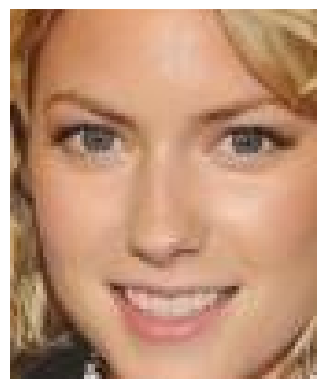

In [8]:
# Watching an image which fed into model
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
render_tensor(img, DEVICE)

---

## Load and train model

In [9]:
def get_efficientnet_b2(num_classes: int, pretrained: bool = True):
    model = models.efficientnet_b2(weights=pretrained).to(DEVICE)
    # Change out_features of last FC-layer
    dim_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(dim_feats, num_classes)

    return model

In [10]:
display(len(train_dataloader.dataset))
display(len(train_dataloader_filled.dataset))

8544

25000

In [11]:
# _____ Define some transformations _____
def custom_norm(x):
    return x/255

normalize_transformer = transforms.Compose([
        custom_norm,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224)),
    ])

augment_n_normalize_transformer = transforms.Compose([
        # augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.5),
        transforms.ColorJitter(
            brightness=0.8,
            contrast=0.8,
            saturation=0.8,
            hue=0.1
        ),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
        # normalizations
        normalize_transformer
    ])

In [12]:
# _____ Define train & test loops _____
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = augment_n_normalize_transformer(X)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * BATCH_SIZE + len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, prefix):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = normalize_transformer(X)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test-{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

    return correct, test_loss

In [13]:
loss_fn = nn.CrossEntropyLoss()

efnet2 = get_efficientnet_b2(num_classes=500, pretrained=True).to(DEVICE)
learning_rate = 1e-3
optimizer = torch.optim.AdamW(efnet2.parameters(), lr=learning_rate)

# _____ Fitting _____

train_losses = []; test_losses = []; val_losses = []
train_accs = []; test_accs = []; val_accs = []

best_test_acc = 0
best_epoch = 0
epochs = 18
for t in range(epochs):
    print(f"_____ Epoch {t+1} _____")
    train_loop(train_dataloader_filled, efnet2, loss_fn, optimizer)
    train_acc, train_loss = test_loop(train_dataloader, efnet2, loss_fn, prefix='train')
    test_acc, test_loss = test_loop(test_dataloader, efnet2, loss_fn, prefix='test')
    val_acc, val_loss = test_loop(val_dataloader, efnet2, loss_fn, prefix='val')
    print()

    # if test_acc > best_test_acc:
    #     best_test_acc = test_acc
    #     best_epoch = t
    #     torch.save(efnet2.state_dict(), f"./checkpoints/efnet2_{best_epoch}.pt")
    
    train_losses.append(train_loss); test_losses.append(test_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); test_accs.append(test_acc); val_accs.append(val_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 217MB/s]


_____ Epoch 1 _____
Test-train Error: 
 Accuracy: 64.5%, Avg loss: 1.430417
Test-test Error: 
 Accuracy: 47.9%, Avg loss: 2.255124
Test-val Error: 
 Accuracy: 47.8%, Avg loss: 2.304600

_____ Epoch 2 _____
Test-train Error: 
 Accuracy: 90.9%, Avg loss: 0.361792
Test-test Error: 
 Accuracy: 66.0%, Avg loss: 1.440175
Test-val Error: 
 Accuracy: 65.2%, Avg loss: 1.493724

_____ Epoch 3 _____
Test-train Error: 
 Accuracy: 95.1%, Avg loss: 0.210019
Test-test Error: 
 Accuracy: 70.2%, Avg loss: 1.297739
Test-val Error: 
 Accuracy: 69.4%, Avg loss: 1.420440

_____ Epoch 4 _____
Test-train Error: 
 Accuracy: 71.7%, Avg loss: 1.735423
Test-test Error: 
 Accuracy: 50.5%, Avg loss: 2.864145
Test-val Error: 
 Accuracy: 53.1%, Avg loss: 2.789486

_____ Epoch 5 _____
Test-train Error: 
 Accuracy: 98.7%, Avg loss: 0.054896
Test-test Error: 
 Accuracy: 75.5%, Avg loss: 1.196235
Test-val Error: 
 Accuracy: 77.0%, Avg loss: 1.238319

_____ Epoch 6 _____
Test-train Error: 
 Accuracy: 96.8%, Avg loss: 0.1

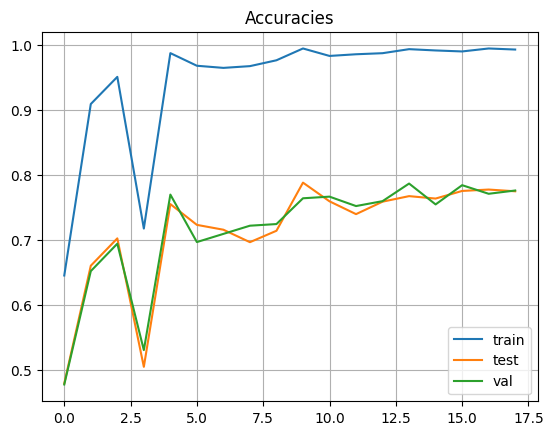

In [14]:
plt.title('Accuracies')
plt.plot(range(epochs), train_accs, label='train')
plt.plot(range(epochs), test_accs, label='test')
plt.plot(range(epochs), val_accs, label='val')

plt.grid()
plt.legend()
plt.show()

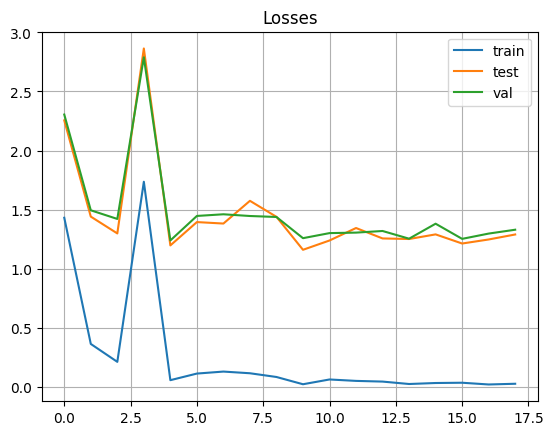

In [15]:
plt.title('Losses')
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.plot(range(epochs), val_losses, label='val')

plt.grid()
plt.legend()
plt.show()

In [16]:
torch.save(efnet2.state_dict(), f"./efnet2_trained.pt")